**Why do we not need collate function for this part of the assignment? Answer:<font color="blue">Collate functions are often used to handle datasets where inputs vary in length, such as natural language processing tasks with variable-length sentences. In those cases, you might need to pad the shorter sequences to match the longest sequence in a batch.
In this case, since all input vectors have a fixed length (e.g., 5000 for TF-IDF vectors), no padding is required and hence we do not need collate functions</font>**

In [2]:
!pip install -U nltk -qq
!pip install -U spacy -qq
!python -m spacy download en_core_web_sm -qq

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 59.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 108.9 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
import sys
basepath = '/content/drive/MyDrive/data'
sys.path.append('/content/drive/MyDrive/Applied NLP/Codes/Custom py classes')

In [5]:
import joblib
stackxg = joblib.load("/content/drive/MyDrive/Applied NLP/Codes/df_multilabel_hw_cleaned.joblib")

**Step 1 - One hot encoding of target labels.**

In [6]:
import ast
from ast import literal_eval
stackxg['Tag_Number'] = stackxg['Tag_Number'].apply(literal_eval)
stackxg.head()

,cleaned_text,Tags,Tag_Number
0,asp query stre dropdown webpage follow control...,c# asp.net,"[0, 9]"
1,run javascript code server java code want run ...,java javascript,"[1, 3]"
2,linq sql throw exception row find change hi li...,c# asp.net,"[0, 9]"
3,run python script php server run nginx web ser...,php python,"[2, 7]"
4,advice write function m try write function res...,javascript jquery,"[3, 5]"


In [7]:
!pip install scikit-learn
from sklearn.preprocessing import MultiLabelBinarizer

In [8]:
mlbinarizer = MultiLabelBinarizer()
targets = mlbinarizer.fit_transform(stackxg['Tag_Number'])
targets

array([[1, 0, 0, ..., 0, 0, 1],
       [0, 1, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 1],
       ...,
       [0, 1, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 1],
       [0, 0, 0, ..., 0, 0, 0]])

**Step 2: Train,validation and  Test Splitting**

In [9]:
from sklearn.model_selection import train_test_split

X, y = list(stackxg['cleaned_text'].values), targets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [10]:
X_train1, X_val, y_train1, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

**Using spacy to do basic cleaning of the dataset**

In [11]:
import CustomPreprocessorSpacy as cp
from FeaturizerSpacy import ManualFeatures
from plot_learning_curve import plot_learning_curve

In [12]:
cp.SpacyPreprocessor

CustomPreprocessorSpacy.SpacyPreprocessor

In [13]:
X_train_cleaned = cp.SpacyPreprocessor(model='en_core_web_sm', batch_size = 100).transform(X_train1)

/content/drive/MyDrive/Applied NLP/Codes/Custom py classes/CustomPreprocessorSpacy.py:83: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  soup = BeautifulSoup(text, "html.parser")
/usr/lib/python3.10/html/parser.py:170: XMLParsedAsHTMLWarning: It looks like you're parsing an XML document using an HTML parser. If this really is an HTML document (maybe it's XHTML?), you can ignore or filter this warning. If it's XML, you should know that using an XML parser will be more reliable. To parse this document as XML, make sure you have the lxml package installed, and pass the keyword argument `features="xml"` into the BeautifulSoup constructor.
  k = self.parse_starttag(i)


In [14]:
X_val_cleaned = cp.SpacyPreprocessor(model='en_core_web_sm', batch_size = 100).transform(X_val)

/usr/local/lib/python3.10/dist-packages/spacy/util.py:1740: UserWarning: [W111] Jupyter notebook detected: if using `prefer_gpu()` or `require_gpu()`, include it in the same cell right before `spacy.load()` to ensure that the model is loaded on the correct device. More information: http://spacy.io/usage/v3#jupyter-notebook-gpu
  warnings.warn(Warnings.W111)


In [15]:
X_test_cleaned = cp.SpacyPreprocessor(model='en_core_web_sm', batch_size = 100).transform(X_test)

**TF-IDF vectorization**

In [16]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Create a TfidfVectorizer with a maximum of 5000 features
tfidf_vectorizer = TfidfVectorizer(max_features=5000)

# Fit on training data
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train_cleaned)

# Transform on validation and test sets
X_valid_tfidf = tfidf_vectorizer.transform(X_val_cleaned)
X_test_tfidf = tfidf_vectorizer.transform(X_test_cleaned)


**Pytorch tensor created for train,val and test datasets**

In [17]:
import torch
from torch.utils.data import TensorDataset

# Convert X and y to tensors
X_train_tensor = torch.tensor(X_train_tfidf.toarray(), dtype=torch.float32)
X_valid_tensor = torch.tensor(X_valid_tfidf.toarray(), dtype=torch.float32)
X_test_tensor = torch.tensor(X_test_tfidf.toarray(), dtype=torch.float32)

y_train_tensor = torch.tensor(y_train1, dtype=torch.float32)
y_valid_tensor = torch.tensor(y_val, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

# Create PyTorch datasets
trainset = TensorDataset(X_train_tensor, y_train_tensor)
validset = TensorDataset(X_valid_tensor, y_valid_tensor)
testset = TensorDataset(X_test_tensor, y_test_tensor)


**Simple Neural Network with layers:Hidden>reLu>Dropout>BatchNorm>Hidden>relu>Dropout>Batchnorm**

In [18]:
import torch.nn as nn

class SimpleNN(nn.Module):
    def __init__(self, input_dim, hidden_dim1, hidden_dim2, output_dim, drop_prob1=0.5, drop_prob2=0.5):
        super(SimpleNN, self).__init__()

        # First hidden layer
        self.hidden1 = nn.Linear(input_dim, hidden_dim1)
        self.relu1 = nn.ReLU()
        self.dropout1 = nn.Dropout(p=drop_prob1)
        self.batchnorm1 = nn.BatchNorm1d(hidden_dim1)

        # Second hidden layer
        self.hidden2 = nn.Linear(hidden_dim1, hidden_dim2)
        self.relu2 = nn.ReLU()
        self.dropout2 = nn.Dropout(p=drop_prob2)
        self.batchnorm2 = nn.BatchNorm1d(hidden_dim2)

        # Output layer
        self.output = nn.Linear(hidden_dim2, output_dim)

    def forward(self, x):
        # Pass through first hidden layer
        x = self.hidden1(x)
        x = self.relu1(x)
        x = self.dropout1(x)
        x = self.batchnorm1(x)

        # Pass through second hidden layer
        x = self.hidden2(x)
        x = self.relu2(x)
        x = self.dropout2(x)
        x = self.batchnorm2(x)

        # Output layer
        x = self.output(x)
        return x


In [19]:
!pip install torchinfo

In [20]:
from torchinfo import summary
import torch

# Define the device
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# Define the model architecture (as in your SimpleNN class)
model = SimpleNN(input_dim=5, hidden_dim1=5, hidden_dim2=3, output_dim=10, drop_prob1=0.5, drop_prob2=0.5)

# Move the model to the device (CPU/GPU)
model = model.to(device)

# Generate some dummy input data to match the expected input dimension for the model
# Here, input_dim is 5, so we need to generate a tensor with that dimension
# Example: Batch size of 2, input dimension 5
dummy_input = torch.randn(2, 5, dtype=torch.float32).to(device)

# Generate summary using torchinfo (note that input_data should be a tensor, not a tuple in this case)
summary(model, input_data=dummy_input, device=device, depth=10, verbose=False)


Layer (type:depth-idx)                   Output Shape              Param #
SimpleNN                                 [2, 10]                   --
├─Linear: 1-1                            [2, 5]                    30
├─ReLU: 1-2                              [2, 5]                    --
├─Dropout: 1-3                           [2, 5]                    --
├─BatchNorm1d: 1-4                       [2, 5]                    10
├─Linear: 1-5                            [2, 3]                    18
├─ReLU: 1-6                              [2, 3]                    --
├─Dropout: 1-7                           [2, 3]                    --
├─BatchNorm1d: 1-8                       [2, 3]                    6
├─Linear: 1-9                            [2, 10]                   40
Total params: 104
Trainable params: 104
Non-trainable params: 0
Total mult-adds (M): 0.00
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.00

In [21]:
# Generate some dummy input data with the correct shape for the SimpleNN
# Example: batch size 2, 5 input features
data = torch.randn(2, 5, dtype=torch.float32).to(device)  # Create random input tensor of shape [2, 5]

# Forward pass through the model
output = model(data)

# Print the output
print(output)


tensor([[ 0.1406,  0.0323,  0.3223,  0.0693, -0.6652, -0.4747, -0.4433, -0.0151,
         -0.0372,  0.3383],
        [-0.6210, -0.8289, -0.2651,  1.0388, -0.4043, -0.3588,  0.7055,  0.7423,
          0.8939,  0.8037]], device='cuda:0', grad_fn=<AddmmBackward0>)


**STEP Function for forward and backward passes**

In [22]:
def step(inputs, targets, model, device, loss_function=None, optimizer=None, CLIP_TYPE="value", CLIP_VALUE=10):
    """
    Performs a forward and backward pass for a given batch of inputs and targets.

    Parameters:
    - inputs (torch.Tensor): The input data for the model (real-valued, not a tuple).
    - targets (torch.Tensor): The true labels for the input data.
    - model (torch.nn.Module): The neural network model.
    - device (torch.device): The computing device (CPU or GPU).
    - loss_function (torch.nn.Module, optional): The loss function to use.
    - optimizer (torch.optim.Optimizer, optional): The optimizer to update model parameters.
    - CLIP_TYPE (str, optional): Type of gradient clipping ('value' or 'norm').
    - CLIP_VALUE (float, optional): Value for gradient clipping.

    Returns:
    - loss (float): The computed loss value (only if loss_function is not None).
    - outputs (torch.Tensor): The predictions from the model.
    - correct (int): The number of correctly classified samples in the batch.
    """
    # Move the model and data to the device
    model = model.to(device)
    inputs = inputs.to(device)  # Inputs should be a dense tensor
    targets = targets.to(device)

    # Step 1: Forward pass to get the model's predictions
    outputs = model(inputs)

    # Step 2a: Compute the loss using the provided loss function
    if loss_function:
        loss = loss_function(outputs, targets)

    # Apply sigmoid to the outputs for multilabel classification
    sigmoid_outputs = torch.sigmoid(outputs)
    predicted = (sigmoid_outputs > 0.5).float()

    # Step 2b: Calculate the number of correctly classified labels
    correct = (predicted == targets).sum().item()

    # Step 3 and 4: Perform backward pass and update model parameters if an optimizer is provided
    if optimizer:
        optimizer.zero_grad()  # Clear gradients
        loss.backward()        # Backward pass to compute gradients

        # Clip gradients before the optimizer step
        if CLIP_TYPE == 'value':
            torch.nn.utils.clip_grad_value_(model.parameters(), CLIP_VALUE)
        elif CLIP_TYPE == 'norm':
            torch.nn.utils.clip_grad_norm_(model.parameters(), CLIP_VALUE)

        optimizer.step()  # Update parameters

    # Return relevant metrics
    if loss_function:
        return loss, outputs, correct
    else:
        return None, outputs, correct


**Evaluation over epochs for train and val**

In [23]:
def train_epoch(train_loader, model, device, loss_function, optimizer):
    """
    Trains the model for one epoch using the provided data loader and updates the model parameters.

    Parameters:
    - train_loader (torch.utils.data.DataLoader): DataLoader object for the training set.
    - model (torch.nn.Module): The neural network model to be trained.
    - device (torch.device): The computing device (CPU or GPU).
    - loss_function (torch.nn.Module): The loss function to use for training.
    - optimizer (torch.optim.Optimizer): The optimizer to update model parameters.

    Returns:
    - train_loss (float): Average training loss for the epoch.
    - train_hamming_loss (float): Training Hamming Loss for the epoch.
    """
    # Set the model to training mode
    model = model.to(device)
    model.train()

    # Initialize variables to track running training loss and Hamming Loss
    running_train_loss = 0.0
    total_hamming_loss = 0.0

    # Iterate over all batches in the training data
    for inputs, targets in train_loader:
        # Move inputs and targets to the appropriate device
        inputs = inputs.to(device)
        targets = targets.to(device)

        # Perform a forward and backward pass, updating model parameters
        loss, outputs, _ = step(inputs, targets, model, device, loss_function, optimizer)

        # Update running loss
        running_train_loss += loss.item()

        # Apply sigmoid and threshold at 0.5 for multilabel classification
        sigmoid_outputs = torch.sigmoid(outputs)
        predicted = (sigmoid_outputs > 0.5).float()

        # Compute Hamming Loss: fraction of incorrect labels
        batch_hamming_loss = (predicted != targets).float().mean().item()

        # Accumulate Hamming Loss
        total_hamming_loss += batch_hamming_loss

    # Compute average loss and Hamming Loss for the entire training set
    train_loss = running_train_loss / len(train_loader)
    train_hamming_loss = total_hamming_loss / len(train_loader)

    return train_loss, train_hamming_loss


In [24]:
def val_epoch(valid_loader, model, device, loss_function, threshold=0.5):
    """
    Validates the model for one epoch using the provided data loader.

    Parameters:
    - valid_loader (torch.utils.data.DataLoader): DataLoader object for the validation set.
    - model (torch.nn.Module): The neural network model to be validated.
    - device (torch.device): The computing device (CPU or GPU).
    - loss_function (torch.nn.Module): The loss function to evaluate the model.
    - threshold (float, optional): Threshold for multilabel classification. Default is 0.5.

    Returns:
    - val_loss (float): Average validation loss for the epoch.
    - val_hamming_loss (float): Validation Hamming Loss for the epoch.
    """
    # Set the model to evaluation mode
    model = model.to(device)
    model.eval()

    # Initialize variables to track running validation loss and Hamming Loss
    running_val_loss = 0.0
    total_hamming_loss = 0.0

    # Disable gradient computation for validation
    with torch.no_grad():
        # Iterate over all batches in the validation data
        for inputs, targets in valid_loader:
            # Move inputs and targets to the appropriate device (CPU or GPU)
            inputs = inputs.to(device)
            targets = targets.to(device)

            # Perform forward pass: compute predicted outputs by passing inputs to the model
            outputs = model(inputs)

            # Compute the loss
            loss = loss_function(outputs, targets)

            # Update running validation loss
            running_val_loss += loss.item()

            # Apply sigmoid and threshold for multilabel classification
            sigmoid_outputs = torch.sigmoid(outputs)
            predictions = (sigmoid_outputs > threshold).float()

            # Compute Hamming Loss: fraction of incorrect labels
            batch_hamming_loss = (predictions != targets).float().mean().item()

            # Accumulate the Hamming Loss
            total_hamming_loss += batch_hamming_loss

    # Compute average loss and Hamming Loss for the entire validation set
    val_loss = running_val_loss / len(valid_loader)
    val_hamming_loss = total_hamming_loss / len(valid_loader)

    return val_loss, val_hamming_loss


**Train function definition**

In [25]:
def train(train_loader, valid_loader, model, optimizer, loss_function, epochs, device,patience=5):
    """
    Trains and validates the model, and returns history of train and validation metrics.

    Parameters:
    - train_loader (torch.utils.data.DataLoader): DataLoader for the training set.
    - valid_loader (torch.utils.data.DataLoader): DataLoader for the validation set.
    - model (torch.nn.Module): Neural network model to train.
    - optimizer (torch.optim.Optimizer): Optimizer algorithm.
    - loss_function (torch.nn.Module): Loss function to evaluate the model.
    - epochs (int): Number of epochs to train the model.
    - device (torch.device): The computing device (CPU or GPU).

    Returns:
    - train_loss_history (list): History of training loss for each epoch.
    - train_hamming_history (list): History of training Hamming Loss for each epoch.
    - valid_loss_history (list): History of validation loss for each epoch.
    - valid_hamming_history (list): History of validation Hamming Loss for each epoch.
    """

    # Initialize lists to store metrics for each epoch
    train_loss_history = []
    valid_loss_history = []
    train_hamming_history = []
    valid_hamming_history = []

    # Loop over the number of specified epochs
    for epoch in range(epochs):
        print(f"Epoch {epoch+1}/{epochs}")

        # Train model on training data and capture metrics
        train_loss, train_hamming_loss = train_epoch(
            train_loader, model, device, loss_function, optimizer)

        # Validate model on validation data and capture metrics
        valid_loss, valid_hamming_loss = val_epoch(
            valid_loader, model, device, loss_function)

        # Store metrics for this epoch
        train_loss_history.append(train_loss)
        train_hamming_history.append(train_hamming_loss)
        valid_loss_history.append(valid_loss)
        valid_hamming_history.append(valid_hamming_loss)

        # Output epoch-level summary
        print(f"Train Loss: {train_loss:.4f} | Train Hamming Loss: {train_hamming_loss:.4f}")
        print(f"Valid Loss: {valid_loss:.4f} | Valid Hamming Loss: {valid_hamming_loss:.4f}")
        print()

        # Early Stopping Logic
        best_val_loss = float('inf')
        epochs_no_improve = 0
        if valid_loss < best_val_loss:
            best_val_loss = valid_loss # Update best validation loss
            epochs_no_improve = 0 # Reset counter
        else:
            epochs_no_improve += 1 # Increment counter if no improvement
              # Check if patience has been reached
        if epochs_no_improve >= patience:
            print(f"Early stopping triggered. No improvement for {patience} consecutive epochs.")
            break # Stop training


    return train_loss_history, train_hamming_history, valid_loss_history, valid_hamming_history


In [26]:
FEATURE_SIZE = 5000
HIDDEN_DIM1 = 200          # Number of neurons in the first hidden layer
HIDDEN_DIM2 = 100          # Number of neurons in the second hidden layer
DROP_PROB1 = 0.5           # Dropout probability for the first hidden layer
DROP_PROB2 = 0.5           # Dropout probability for the second hidden layer
NUM_OUTPUTS = 10           # Number of output labels (for multilabel classification)
BATCH_SIZE = 128           # Batch size for training
LEARNING_RATE = 0.001      # Learning rate for AdamW optimizer
PATIENCE = 5
EPOCHS = 5

In [27]:
# Fixing the seed value for reproducibility across runs
import random
import numpy as np
import torch

SEED = 2345
random.seed(SEED)                     # Set seed for Python's 'random' module
np.random.seed(SEED)                  # Set seed for NumPy's random number generation
torch.manual_seed(SEED)               # Set seed for PyTorch's CPU operations
torch.cuda.manual_seed(SEED)          # Set seed for PyTorch's CUDA (GPU) operations
torch.backends.cudnn.deterministic = True  # Ensure deterministic behavior in CuDNN

# Define data loaders for training, validation, and test sets
# Make sure trainset, validset, and testset are dense feature datasets (e.g., TF-IDF features)
train_loader = torch.utils.data.DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
valid_loader = torch.utils.data.DataLoader(validset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)
test_loader = torch.utils.data.DataLoader(testset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

# Define the loss function for the model, using binary cross-entropy loss for multilabel classification
loss_function = torch.nn.BCEWithLogitsLoss()

# Define the model architecture
model_imdb = SimpleNN(input_dim=FEATURE_SIZE,       # Number of features (e.g., 5000 if using TF-IDF with max_features=5000)
                      hidden_dim1=HIDDEN_DIM1,   # Number of neurons in the first hidden layer
                      hidden_dim2=HIDDEN_DIM2,   # Number of neurons in the second hidden layer
                      output_dim=NUM_OUTPUTS,    # Number of output labels (multilabel classification)
                      drop_prob1=DROP_PROB1,     # Dropout probability for first hidden layer
                      drop_prob2=DROP_PROB2)     # Dropout probability for second hidden layer

# Initialize the optimizer for training, using AdamW optimizer with the specified learning rate
optimizer = torch.optim.AdamW(model_imdb.parameters(), lr=LEARNING_RATE)

# Define the device for model training (use CUDA if available, else CPU)
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# Move the model to the selected device (GPU or CPU)
model_imdb = model_imdb.to(device)


**Evaluate loss of untrained model and compare it with theoretical loss**

In [28]:
# Ensure the model is on the correct device
model_imdb = model_imdb.to(device)

for inputs, targets in train_loader:
    # Move inputs and targets to the device (CPU or GPU)
    inputs = inputs.to(device)
    targets = targets.to(device).float()

    # Set model to evaluation mode
    model_imdb.eval()

    # Forward pass (no gradients needed since this is evaluation)
    with torch.no_grad():
        output = model_imdb(inputs)  # Forward pass with inputs

        # Compute loss
        loss = loss_function(output, targets)

        # Print the actual loss for the batch
        print(f'Actual loss: {loss.item()}')

    # Break after the first batch (since we're testing)
    break

# Theoretical loss when all predicted probabilities are 0.5 (used in BCEWithLogitsLoss)
print(f'Expected Theoretical loss: {-1*np.log(0.5)}')


Actual loss: 0.6800308227539062
Expected Theoretical loss: 0.6931471805599453


**Model Training**

In [29]:
train_losses, train_acc, valid_losses, valid_acc = train(
    train_loader, valid_loader, model_imdb, optimizer, loss_function, EPOCHS, device
)

Epoch 1/5
Train Loss: 0.3372 | Train Hamming Loss: 0.1322
Valid Loss: 0.1443 | Valid Hamming Loss: 0.0502

Epoch 2/5
Train Loss: 0.1371 | Train Hamming Loss: 0.0487
Valid Loss: 0.1203 | Valid Hamming Loss: 0.0450

Epoch 3/5
Train Loss: 0.1095 | Train Hamming Loss: 0.0403
Valid Loss: 0.1133 | Valid Hamming Loss: 0.0424

Epoch 4/5
Train Loss: 0.0937 | Train Hamming Loss: 0.0342
Valid Loss: 0.1094 | Valid Hamming Loss: 0.0402

Epoch 5/5
Train Loss: 0.0846 | Train Hamming Loss: 0.0308
Valid Loss: 0.1083 | Valid Hamming Loss: 0.0389



**Performance plots of model over epochs during training and validation**

In [30]:
import matplotlib.pyplot as plt
import seaborn as sns
def plot_history(train_losses, train_metrics, val_losses=None, val_metrics=None):
    """
    Plot training and validation loss and metrics over epochs.

    Args:
        train_losses (list): List of training losses for each epoch.
        train_metrics (list): List of training metrics (e.g., accuracy) for each epoch.
        val_losses (list, optional): List of validation losses for each epoch.
        val_metrics (list, optional): List of validation metrics for each epoch.

    Returns:
        None
    """
    # Determine the number of epochs based on the length of train_losses
    epochs = range(1, len(train_losses) + 1)

    # Plotting training and validation losses
    plt.figure()
    #print(train_losses)
    plt.plot(epochs, train_losses, label="Train")  # Plot training losses
    if val_losses:  # Check if validation losses are provided
        plt.plot(epochs, val_losses, label="Validation")  # Plot validation losses
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

    # Plotting training and validation metrics
    if train_metrics[0] is not None:
       # print("hi") # Check if training metrics are available
        plt.figure()
        plt.plot(epochs, train_metrics, label="Train")  # Plot training metrics
        if val_metrics:  # Check if validation metrics are provided
            plt.plot(epochs, val_metrics, label="Validation")  # Plot validation metrics
        plt.xlabel("Epochs")
        plt.ylabel("Metric")
        plt.legend()
        plt.show()

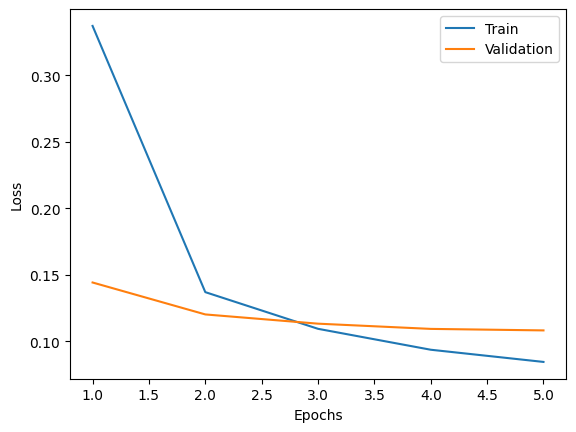

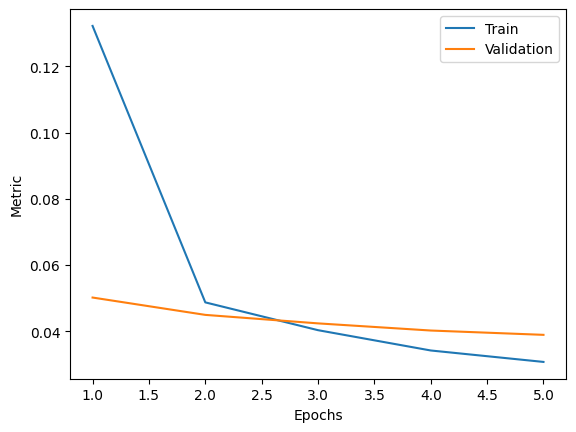

In [31]:
plot_history(train_losses, train_acc, valid_losses, valid_acc)

**Evaluation on test dataset***

In [32]:
def test_model(test_loader, model, device, loss_function, threshold=0.5):
    """
    Tests the model on the test dataset.

    Args:
        test_loader (DataLoader): DataLoader object for the test set.
        model (nn.Module): Trained neural network model.
        device (torch.device): Device to perform computation (CPU/GPU).
        loss_function (nn.Module): Loss function to compute the test loss.
        threshold (float, optional): Threshold for multilabel classification.

    Returns:
        avg_test_loss (float): Average loss on the test dataset.
        test_hamming_loss (float): Hamming Loss on the test dataset.
    """
    model.eval()  # Set the model to evaluation mode
    running_test_loss = 0.0
    total_hamming_loss = 0.0
    num_batches = 0

    with torch.no_grad():  # Disable gradient calculation
        for inputs, targets in test_loader:
            # Move inputs and targets to the device
            inputs = inputs.to(device)
            targets = targets.to(device).float()

            # Forward pass to get outputs
            outputs = model(inputs)

            # Compute the loss
            loss = loss_function(outputs, targets)
            running_test_loss += loss.item()

            # Apply sigmoid to get probabilities, then threshold to classify
            sigmoid_outputs = torch.sigmoid(outputs)
            predictions = (sigmoid_outputs > threshold).float()

            # Compute Hamming Loss: fraction of incorrect labels
            batch_hamming_loss = (predictions != targets).float().mean().item()
            total_hamming_loss += batch_hamming_loss

            num_batches += 1

    # Compute average test loss and Hamming Loss
    avg_test_loss = running_test_loss / num_batches
    avg_hamming_loss = total_hamming_loss / num_batches

    print(f"Test Loss: {avg_test_loss:.4f}, Test Hamming Loss: {avg_hamming_loss:.4f}")

    return avg_test_loss, avg_hamming_loss


In [33]:
# Assuming test_loader, model, device, and loss_function are defined
test_loss, test_hamming_loss = test_model(test_loader, model_imdb, device, loss_function)

# Print results
print(f"Test Loss: {test_loss}, Test Hamming Loss: {test_hamming_loss}")


Test Loss: 0.1075, Test Hamming Loss: 0.0391
Test Loss: 0.10753418137629826, Test Hamming Loss: 0.03907886972030004


**INFERENCE:**
**The model used in this part was a simple neural network(no embedding bag). The features were created using TF-IDF vectorization with a max features of 5000.
We can see from the performance plots and metrics that the model performed better over consecutive epochs with the clear drop in losses and the reduced hamming distances.
From the performance on the test dataset we can see that both models in part A and part B have similar metrics,indicating that both models would be able to generalize equally well on unseen data.**

#### 2. **Training Process**:
   - The model was trained for **5 epochs** with early stopping, with a patience of **5** epochs to prevent overfitting if the validation loss didn’t improve.

#### 3. **Hyperparameters**:
   - **Hidden Layer Dimensions**: 200 and 100 neurons, respectively.
   - **Dropout Probability**: 0.5 for both hidden layers to avoid overfitting.
   - **Learning Rate**: 0.001, using the AdamW optimizer.
   - **Batch Size**: 128

#### 4. **Performance Metrics**:
   - The performance of the model was evaluated using **Hamming Loss**, which measures the fraction of labels that are incorrectly predicted for each sample. Lower values of Hamming Loss indicate better performance.
   - **Training and Validation Results**:
     Epoch 1/5
      Train Loss: 0.3372 | Train Hamming Loss: 0.1322
      Valid Loss: 0.1443 | Valid Hamming Loss: 0.0502

    Epoch 5/5
    Train Loss: 0.0846 | Train Hamming Loss: 0.0308
    Valid Loss: 0.1083 | Valid Hamming Loss: 0.0389

#### 5. **Test Set Evaluation**:
   - After training, the model was evaluated on the test set to measure generalization to unseen data.
   - **Test Results**:
     - **Test Loss**: 0.1075
     - **Test Hamming Loss**: 0.039
   - These results demonstrate that the model generalized well, with low Hamming Loss on both the validation and test sets, indicating the model's predictions were accurate for most labels.

#### 6. **Observations and Insights**:
   - **Early Stopping**: The early stopping mechanism prevented the model from overfitting, as it stopped training after 5 epochs where no significant improvements were observed in the validation loss.
   - **Performance on Multilabel Classification**: The model achieved a low Hamming Loss, demonstrating that it was able to predict multiple labels for each sample with a high degree of accuracy.
   - **Training Stability**: Both training and validation losses decreased consistently over the epochs, showing that the model did not overfit and learned effectively from the training data.


In [45]:
def run_inference(model, text, device, threshold=0.5):
    """
    Run inference on the test set using the trained model.

    Parameters:
    - model (nn.Module): The trained model.
    - text (Tensor): Preprocessed input data (e.g., TF-IDF vectors).
    - device (torch.device): The device to perform inference (CPU/GPU).
    - threshold (float): Threshold for converting probabilities to binary predictions (default: 0.5).

    Returns:
    - transformed_classes (list): List of indices for the predicted classes for each instance.
    - predicted_classes (list): One-hot encoded predictions (0/1 for each label).
    """
    # Move model to the device and set it to evaluation mode
    model = model.to(device)
    model.eval()

    # Ensure input is 2D, even for single samples (batch_size, num_features)
    if text.dim() == 1:
        text = text.unsqueeze(0)

    # Move input to the device
    text = text.to(device)

    # Disable gradient calculations for inference
    with torch.no_grad():
        # Pass the text (preprocessed vector) to the model to get logits
        logits = model(text)

        # Apply sigmoid to convert logits to probabilities
        probabilities = torch.sigmoid(logits)

        # Apply threshold to get binary predictions (0 or 1)
        predictions = (probabilities > threshold).float()

    # Convert predictions to a list of class labels (0/1)
    predicted_classes = predictions.cpu().numpy().tolist()

    # Transform binary predictions to class indices
    transformed_classes = []
    for i in range(len(predicted_classes)):
        instance_classes = []
        for j in range(len(predicted_classes[i])):
            if predicted_classes[i][j] == 1.0:
                instance_classes.append(j)
        transformed_classes.append(instance_classes)

    return transformed_classes, predicted_classes

# Example Usage:
# Assuming `model_imdb` is the trained model, and `X_test_tensor` is the vectorized test dataset.
for i in range(5):
    transformed, predictions = run_inference(model_imdb, X_test_tensor[i], device)

    # Print the predicted class labels
    print(f"Transformed Predictions: observation {i}: {transformed}")
    print(f"One-hot Predictions: observation {i}: {predictions}")


Transformed Predictions: observation 0: [[3, 5]]
One-hot Predictions: observation 0: [[0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0]]
Transformed Predictions: observation 1: [[0, 9]]
One-hot Predictions: observation 1: [[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0]]
Transformed Predictions: observation 2: [[1, 4]]
One-hot Predictions: observation 2: [[0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0]]
Transformed Predictions: observation 3: [[0]]
One-hot Predictions: observation 3: [[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]]
Transformed Predictions: observation 4: [[3, 5]]
One-hot Predictions: observation 4: [[0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0]]
